In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# Loading Excel data
data = pd.read_csv('bank2.csv')

- Input variables:
    - bank client data:
        - age (numeric)
        - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
        - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
        - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
        - default: has credit in default? (categorical: 'no','yes','unknown')
        - housing: has housing loan? (categorical: 'no','yes','unknown')
        - loan: has personal loan? (categorical: 'no','yes','unknown')related with the last contact of the current campaign:
        - contact: contact communication type (categorical: 'cellular','telephone')
        - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
        - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

    - other attributes:
        - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
        - previous: number of contacts performed before this campaign and for this client (numeric)
        - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

    - social and economic context attributes:
        - emp.var.rate: employment variation rate - quarterly indicator (numeric)
        - cons.price.idx: consumer price index - monthly indicator (numeric)
        - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
        - euribor3m: euribor 3 month rate - daily indicator (numeric)
        - nr.employed: number of employees - quarterly indicator (numeric)

- Output variable (desired target):
     - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [16]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

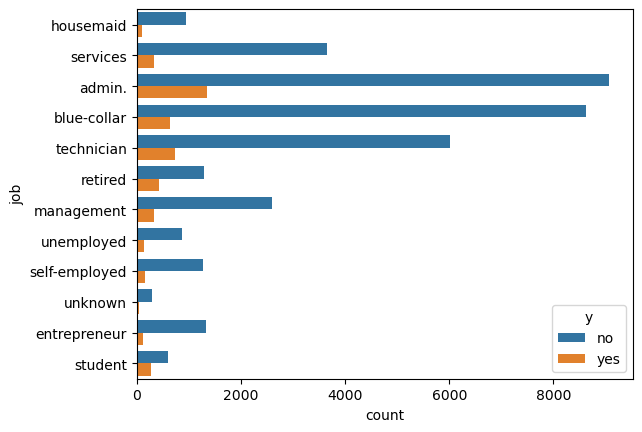

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

In [17]:
sns.countplot(y='job', hue='y', data=data)
plt.show()
data = data[data['job'] != 'unknown']
data['job'].value_counts()

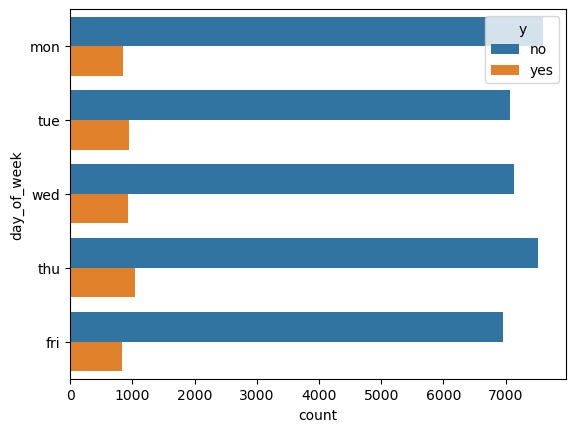

C:\Users\lph\AppData\Local\Temp\ipykernel_20892\1572826800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('day_of_week', axis=1, inplace=True)


In [18]:
sns.countplot(y='day_of_week', hue='y', data=data)
plt.show()
data.drop('day_of_week', axis=1, inplace=True)

In [19]:
# 创建独热编码的DataFrame
job_dummies = pd.get_dummies(data['job'], prefix='job')

# 将独热编码的DataFrame添加到原始数据中
data_encoded = pd.concat([data, job_dummies], axis=1)

# 删除原始的'job'列
data_encoded.drop(columns=['job'], inplace=True)

data=data_encoded

# 输出编码后的数据集
data

,age,marital,education,default,housing,loan,contact,month,campaign,pdays,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,56,married,basic.4y,no,no,no,telephone,may,1,999,...,0,0,1,0,0,0,0,0,0,0
1,57,married,high.school,unknown,no,no,telephone,may,1,999,...,0,0,0,0,0,0,1,0,0,0
2,37,married,high.school,no,yes,no,telephone,may,1,999,...,0,0,0,0,0,0,1,0,0,0
3,40,married,basic.6y,no,no,no,telephone,may,1,999,...,0,0,0,0,0,0,0,0,0,0
4,56,married,high.school,no,no,yes,telephone,may,1,999,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,married,professional.course,no,yes,no,cellular,nov,1,999,...,0,0,0,0,1,0,0,0,0,0
41184,46,married,professional.course,no,no,no,cellular,nov,1,999,...,1,0,0,0,0,0,0,0,0,0
41185,56,married,university.degree,no,yes,no,cellular,nov,2,999,...,0,0,0,0,1,0,0,0,0,0
41186,44,married,professional.course,no,no,no,cellular,nov,1,999,...,0,0,0,0,0,0,0,0,1,0


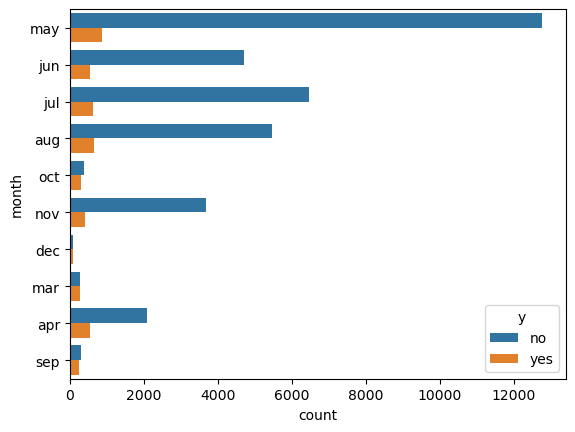

In [20]:
sns.countplot(y='month', hue='y', data=data)
plt.show()
data['month'].replace([ 'jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)

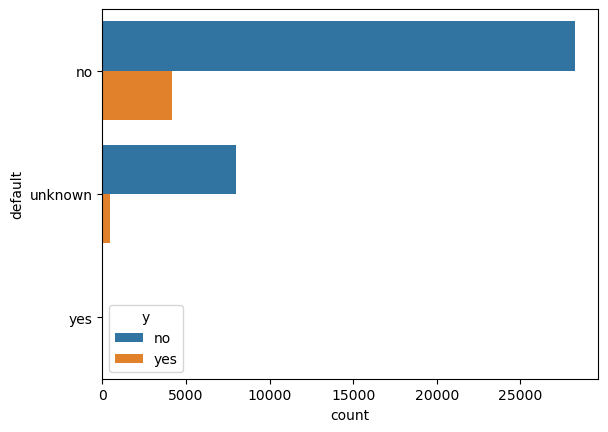

default,no,unknown,yes
y,,,
no,28243,8009,3
yes,4167,436,0


In [21]:
sns.countplot(y='default', hue='y', data=data)
plt.show()
contingency_table = pd.crosstab(data['y'], data['default'])
contingency_table

In [22]:
contingency_table = pd.crosstab(data['y'], data['default'])
contingency_table
data.drop(columns=['default'], inplace=True)

In [23]:
data['poutcome'].value_counts()

nonexistent    35270
failure         4234
success         1354
Name: poutcome, dtype: int64

In [24]:
data['pdays'].value_counts()

999    39363
3        431
6        406
4        117
9         64
7         60
2         59
12        58
10        52
5         46
13        35
11        28
1         25
15        24
14        20
8         17
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

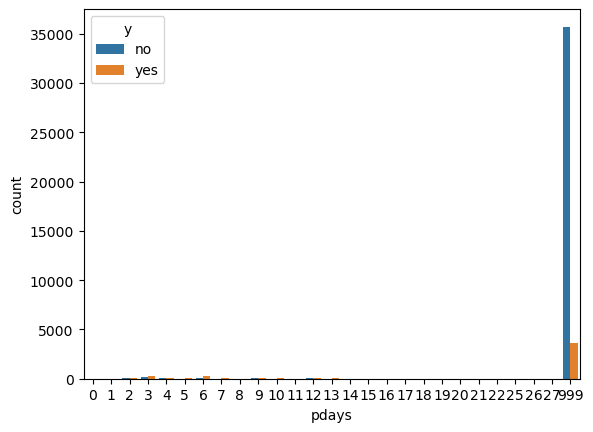

In [25]:
sns.countplot(x='pdays', hue='y', data=data)
plt.show()

In [26]:
data['pdays_category'] = data['pdays']
data['pdays_category'] = data['pdays'].apply(lambda x: 1 if x < 999 else 0)
data.drop(columns=['pdays'], inplace=True)
contingency_table = pd.crosstab(data['y'], data['pdays_category'])
contingency_table

pdays_category,0,1
y,,
no,35720,535
yes,3643,960


In [27]:
#data['emp_var_rate_euribor3m_sum'] = data['emp.var.rate'] + data['euribor3m']

In [28]:
# 创建新的变量'has_poutcome'表示存在'poutcome'
data['has_poutcome'] = data['poutcome']
data['has_poutcome'].replace([ 'failure','nonexistent','success'],[1,0,1],inplace=True)

# 创建新的变量'poutcome_success'表示'poutcome'成功
data['poutcome_success'] = data['poutcome']
data['poutcome_success'].replace([ 'failure','nonexistent','success'],[0,0,1],inplace=True)

# 删除原始的'poutcome'列
data.drop(columns=['poutcome'], inplace=True)

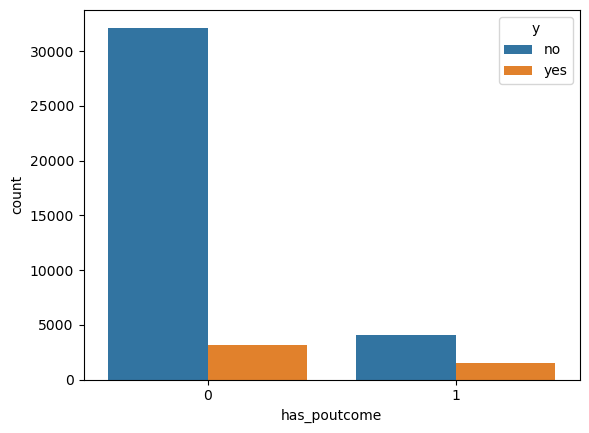

has_poutcome,0,1
y,,
no,32151,4104
yes,3119,1484


In [29]:
data['has_poutcome'].value_counts()
sns.countplot(x='has_poutcome', hue='y', data=data)
plt.show()
contingency_table = pd.crosstab(data['y'], data['has_poutcome'])
contingency_table

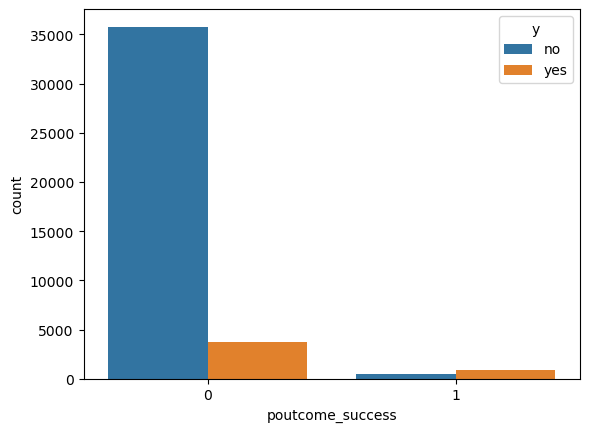

poutcome_success,0,1
y,,
no,35789,466
yes,3715,888


In [30]:
data['poutcome_success'].value_counts()
sns.countplot(x='poutcome_success', hue='y', data=data)
plt.show()
contingency_table = pd.crosstab(data['y'], data['poutcome_success'])
contingency_table

In [31]:
# 删除'housing'变量中的'unknown'值所在的行
data = data[data['housing'] != 'unknown']
data = data[data['marital'] != 'unknown']
data = data[data['education'] != 'unknown']

data['education'].replace(['illiterate', 'basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree'],[0,4,6,9,13,15,17],inplace=True)
data['marital'].replace(['married','single','divorced'],[1,0,0],inplace=True)
data['housing'].replace(['no','yes'],[0,1],inplace=True)
data['loan'].replace(['no','yes'],[0,1],inplace=True)
data['contact'].replace([ 'cellular','telephone'],[0,1],inplace=True)

In [32]:
data['marital'].value_counts()

1    23183
0    15062
Name: marital, dtype: int64

In [33]:
data['y'].replace(['no', 'yes'], [0, 1], inplace=True)
data

,age,marital,education,housing,loan,contact,month,campaign,previous,emp.var.rate,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,pdays_category,has_poutcome,poutcome_success
0,56,1,4,0,0,1,4,1,0,1.1,...,0,0,0,0,0,0,0,0,0,0
1,57,1,13,0,0,1,4,1,0,1.1,...,0,0,0,1,0,0,0,0,0,0
2,37,1,13,1,0,1,4,1,0,1.1,...,0,0,0,1,0,0,0,0,0,0
3,40,1,6,0,0,1,4,1,0,1.1,...,0,0,0,0,0,0,0,0,0,0
4,56,1,13,0,1,1,4,1,0,1.1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,15,1,0,0,10,1,0,-1.1,...,0,1,0,0,0,0,0,0,0,0
41184,46,1,15,0,0,0,10,1,0,-1.1,...,0,0,0,0,0,0,0,0,0,0
41185,56,1,17,1,0,0,10,2,0,-1.1,...,0,1,0,0,0,0,0,0,0,0
41186,44,1,15,0,0,0,10,1,0,-1.1,...,0,0,0,0,0,1,0,0,0,0


In [34]:
data['has_poutcome'].value_counts()

0    33066
1     5179
Name: has_poutcome, dtype: int64

In [35]:
# 假设 'data' 是包含你的数据集的DataFrame
X = data.drop(columns=['y'])  # 特征变量
y = data['y']  # 目标变量

# 初始化SMOTE对象
smote = SMOTE(random_state=42)

# 对数据进行过采样，生成新的样本
X_resampled, y_resampled = smote.fit_resample(X, y)

# 将生成的新样本合并成新的DataFrame
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# 输出新的样本数据分布
print(data_resampled['y'].value_counts())

0    33987
1    33987
Name: y, dtype: int64


In [36]:
data['poutcome_success'].value_counts()

0    37002
1     1243
Name: poutcome_success, dtype: int64

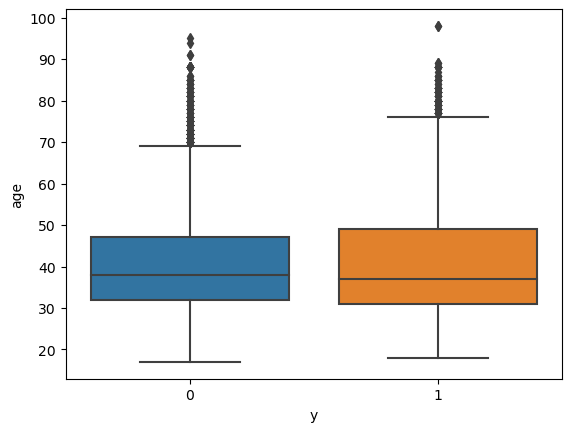

In [37]:
sns.boxplot(x='y', y='age', data=data)
plt.show()

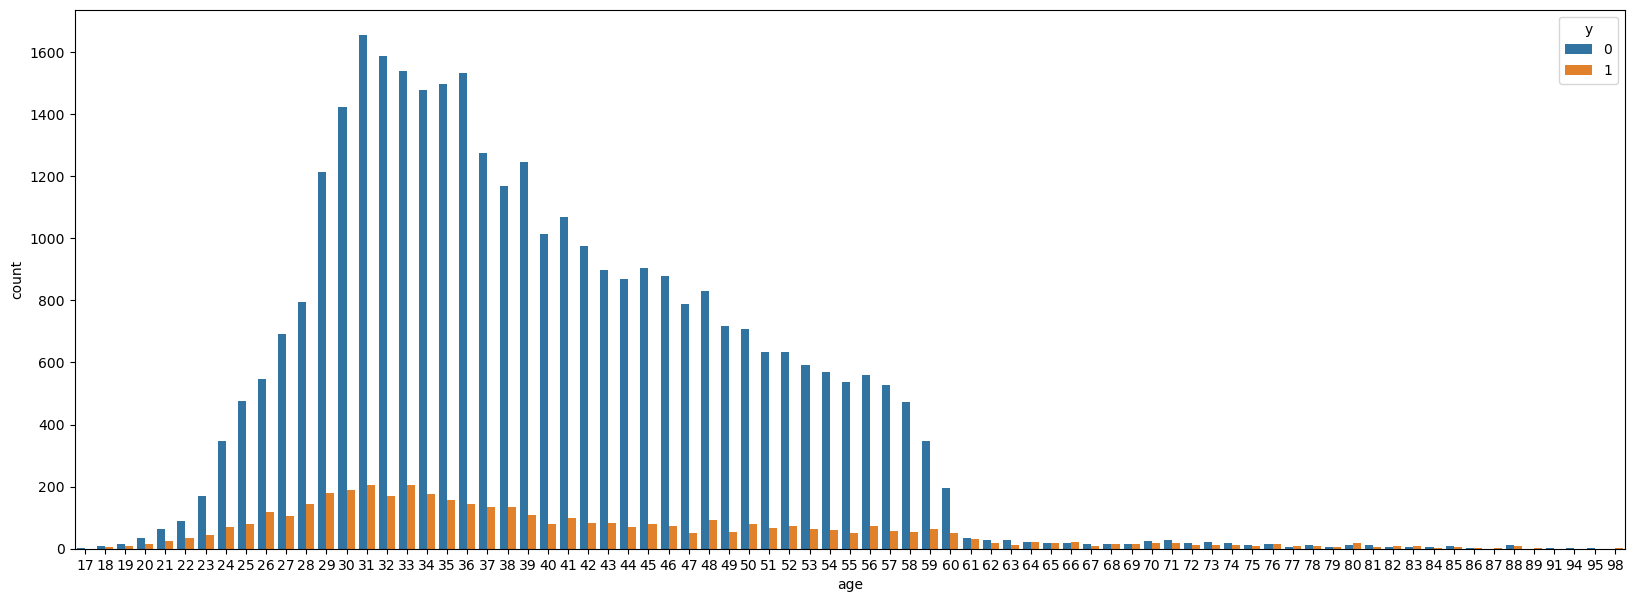

In [38]:
plt.figure(figsize=(20,7))
sns.countplot(x='age', hue='y', data=data)
plt.show()

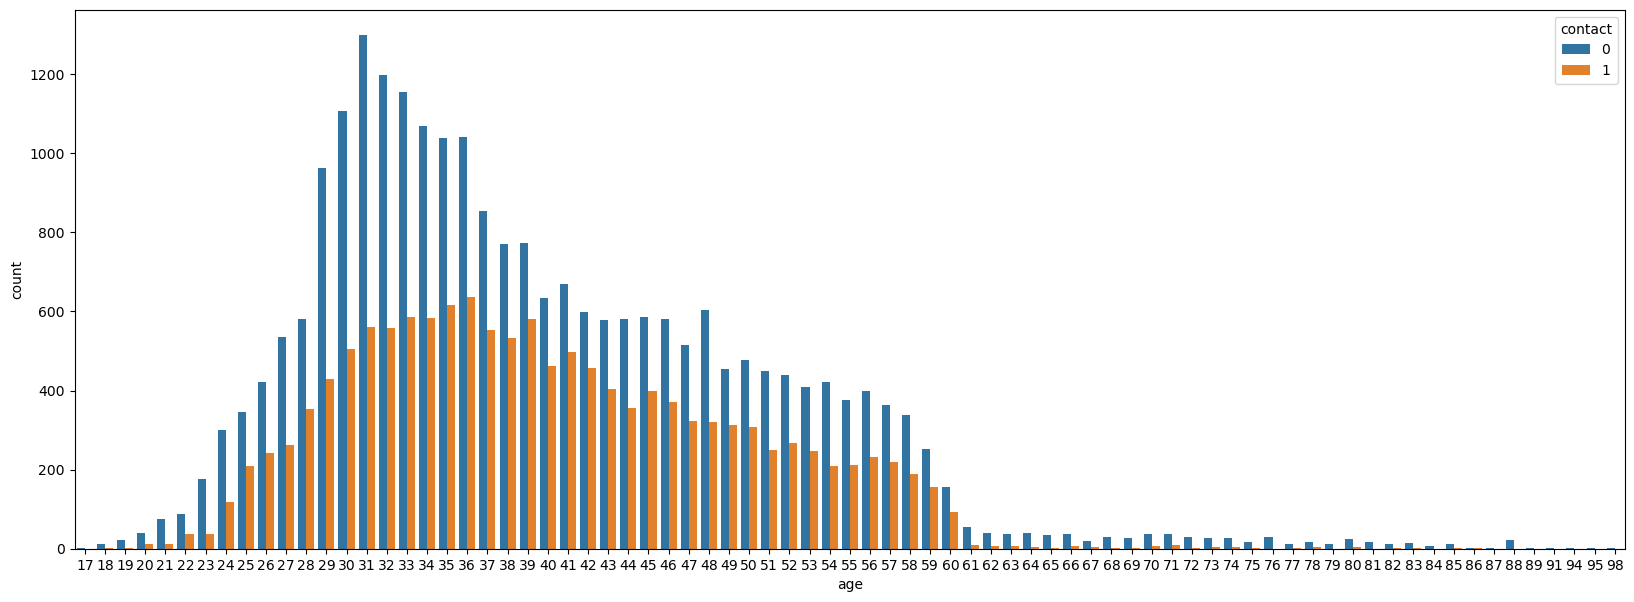

In [39]:
plt.figure(figsize=(20,7))
sns.countplot(x='age', hue='contact', data=data)
plt.show()

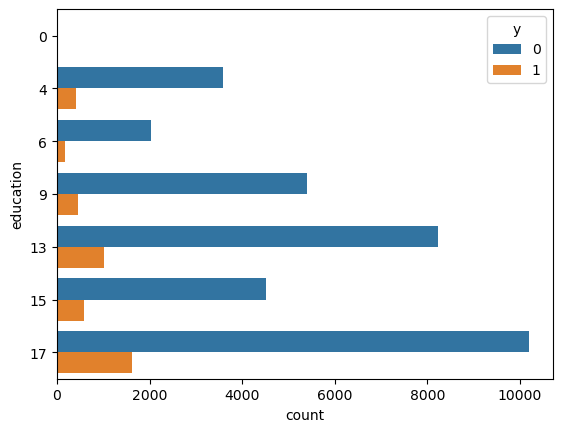

In [40]:
sns.countplot(y='education', hue='y', data=data)
plt.show()

In [41]:
contingency_table = pd.crosstab(data['y'], data['education'])
contingency_table

education,0,4,6,9,13,15,17
y,,,,,,,
0,14,3590,2024,5399,8237,4522,10201
1,4,412,180,457,1007,578,1620


In [42]:
'''data=unresampled_data
bins = [0.7, 0.8, 0.9, 1.0, np.inf]
labels = [ 'Young adults', 'Middle-aged adults','older adults', 'elderly']
data['AgeGroup'] = pd.cut(data["age"], bins, labels = labels)
sns.stripplot(y='nr.employed', x='euribor.3m', data=data)
plt.show()'''

'data=unresampled_data\nbins = [0.7, 0.8, 0.9, 1.0, np.inf]\nlabels = [ \'Young adults\', \'Middle-aged adults\',\'older adults\', \'elderly\']\ndata[\'AgeGroup\'] = pd.cut(data["age"], bins, labels = labels)\nsns.stripplot(y=\'nr.employed\', x=\'euribor.3m\', data=data)\nplt.show()'

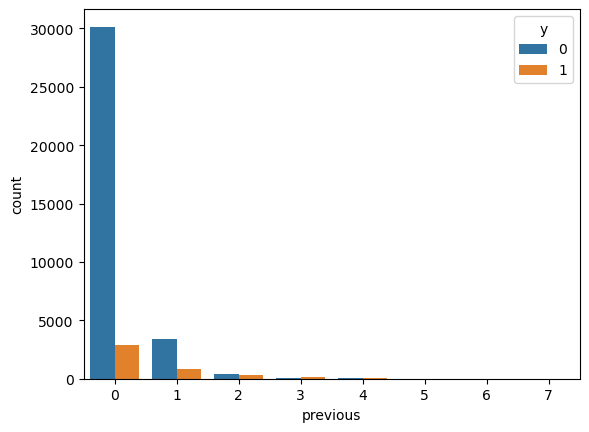

In [43]:
sns.countplot(x='previous', hue='y', data=data)
plt.show()

In [44]:
contingency_table = pd.crosstab(data['y'], data['previous'])
contingency_table

previous,0,1,2,3,4,5,6,7
y,,,,,,,,
0,30144,3364,366,78,27,5,2,1
1,2922,870,306,117,30,11,2,0


In [45]:
unresampled_data=data
data=data_resampled

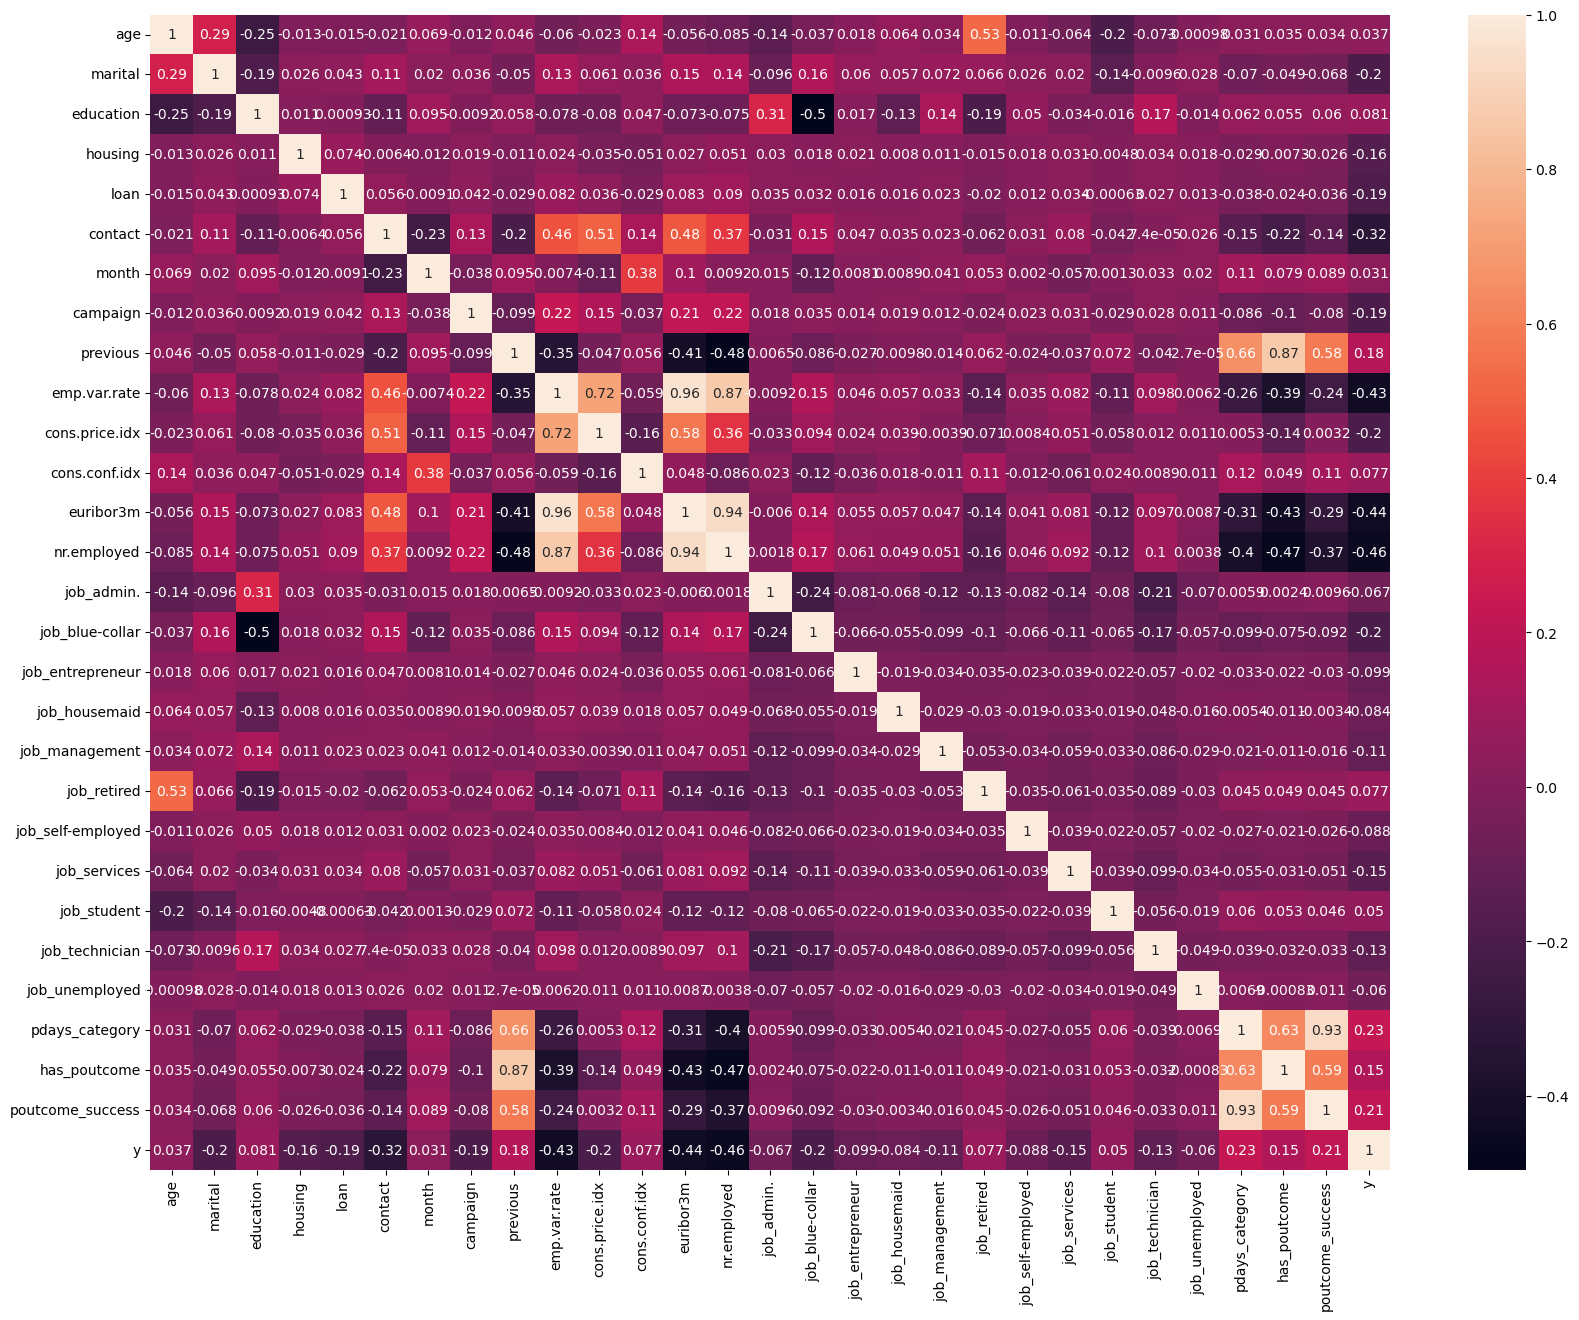

In [46]:
plt.figure(figsize=(20,15))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [47]:
data.drop(columns=['contact'], inplace=True)
data.drop(columns=['previous'], inplace=True)
data.drop(columns=['emp.var.rate'], inplace=True)
data.drop(columns=['euribor3m'], inplace=True)
data.drop(columns=['nr.employed'], inplace=True)
data.drop(columns=['pdays_category'], inplace=True)
data.drop(columns=['poutcome_success'], inplace=True)

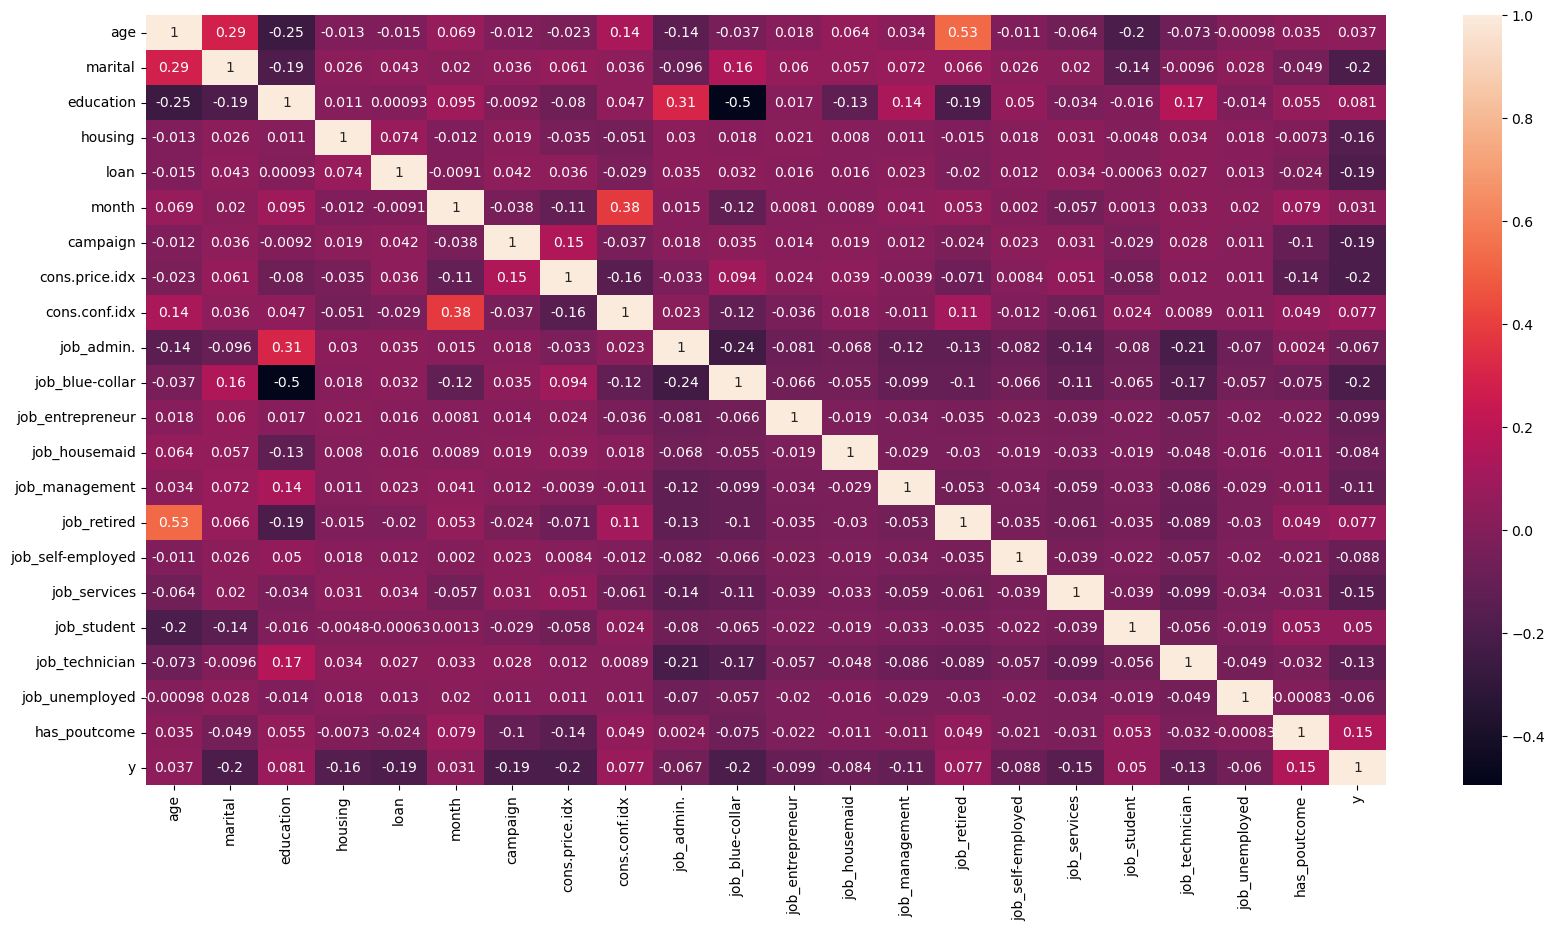

In [48]:
plt.figure(figsize=(20,10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

C:\Users\lph\anaconda2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7796248620816477
Confusion Matrix:
[[5860  893]
 [2103 4739]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      6753
           1       0.84      0.69      0.76      6842

    accuracy                           0.78     13595
   macro avg       0.79      0.78      0.78     13595
weighted avg       0.79      0.78      0.78     13595

AUC Score: 0.8563193930329794


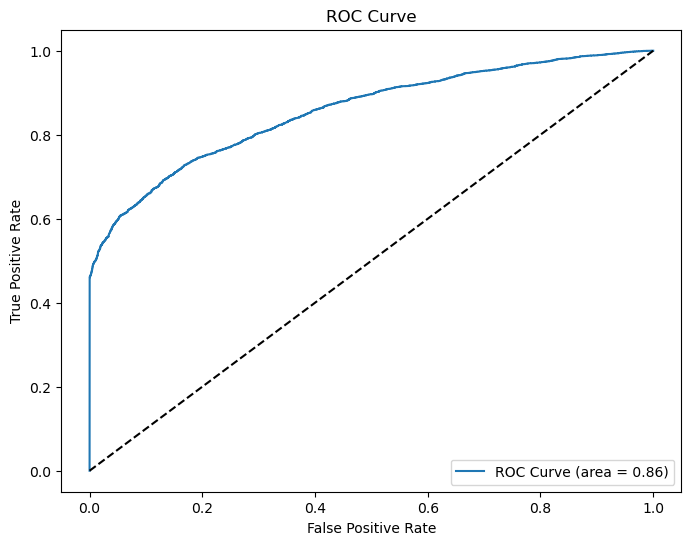

C:\Users\lph\anaconda2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lph\anaconda2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistics Model (Cross Validation Scores):
Accuracy Scores: [0.52997426 0.81500552 0.81397573 0.70923134 0.69339414]
Mean Accuracy: 0.7123161955740269


C:\Users\lph\anaconda2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
#Logistics Model
X = data.drop(columns=['y'])  # 选择所有除了'y'以外的其他变量作为自变量
y = data['y']

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建多元逻辑回归模型
model = LogisticRegression(max_iter=1000)  # 设置max_iter以允许模型收敛
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


# 计算ROC曲线
y_pred_prob = model.predict_proba(X_test)[:, 1]  # 获取预测为1的概率
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 计算AUC值
auc_score = roc_auc_score(y_test, y_pred_prob)

# 打印模型性能指标
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print("AUC Score:", auc_score)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
# Perform cross-validation
logistic_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Logistics Model (Cross Validation Scores):")
print("Accuracy Scores:", logistic_scores)
print("Mean Accuracy:", logistic_scores.mean())

In [50]:
#SVM Model
# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建支持向量机模型
svm_model = SVC(kernel='linear', random_state=42)  # 选择线性核函数
svm_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_svm = svm_model.predict(X_test)

# 评估模型性能
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

# 打印模型性能指标
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)
print("Classification Report:")
print(classification_rep_svm)
# Perform cross-validation
#svm_scores = cross_val_score(svm_model, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
#print("SVM Model (Cross Validation Scores):")
#print("Accuracy Scores:", svm_scores)
#print("Mean Accuracy:", svm_scores.mean())

SVM Model:
Accuracy: 0.78411180581096
Confusion Matrix:
[[5962  791]
 [2144 4698]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      6753
           1       0.86      0.69      0.76      6842

    accuracy                           0.78     13595
   macro avg       0.80      0.78      0.78     13595
weighted avg       0.80      0.78      0.78     13595



In [51]:
# LDA Model
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)

# Predict on the test set
y_pred_lda = model_lda.predict(X_test)

# Evaluate the model
accuracy_lda = accuracy_score(y_test, y_pred_lda)
conf_matrix_lda = confusion_matrix(y_test, y_pred_lda)
classification_rep_lda = classification_report(y_test, y_pred_lda)

# Print the evaluation metrics
print("LDA Model:")
print("Accuracy:", accuracy_lda)
print("Confusion Matrix:")
print(conf_matrix_lda)
print("Classification Report:")
print(classification_rep_lda)
# Perform cross-validation
#lda_scores = cross_val_score(model_lda, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
'''print("LDA Model (Cross Validation Scores):")
print("Accuracy Scores:", lda_scores)
print("Mean Accuracy:", lda_scores.mean())'''

LDA Model:
Accuracy: 0.7858771607208532
Confusion Matrix:
[[6023  730]
 [2181 4661]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.81      6753
           1       0.86      0.68      0.76      6842

    accuracy                           0.79     13595
   macro avg       0.80      0.79      0.78     13595
weighted avg       0.80      0.79      0.78     13595



'print("LDA Model (Cross Validation Scores):")\nprint("Accuracy Scores:", lda_scores)\nprint("Mean Accuracy:", lda_scores.mean())'

In [52]:
X = data.drop(columns=['y'])  # Independent variables
y = data['y']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Model:")
print("Accuracy:", accuracy_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)
print("Classification Report:")
print(classification_rep_xgb)

# Perform cross-validation
xgb_scores = cross_val_score(model_xgb, X, y, cv=5)  # 5-fold cross-validation
# Print the cross-validation scores
print("XGBoost Model (Cross Validation Scores):")
print("Accuracy Scores:", xgb_scores)
print("Mean Accuracy:", xgb_scores.mean())

XGBoost Model:
Accuracy: 0.8707613093048915
Confusion Matrix:
[[6150  603]
 [1154 5688]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      6753
           1       0.90      0.83      0.87      6842

    accuracy                           0.87     13595
   macro avg       0.87      0.87      0.87     13595
weighted avg       0.87      0.87      0.87     13595

XGBoost Model (Cross Validation Scores):
Accuracy Scores: [0.4353071  0.6336153  0.76211843 0.54946672 0.55215536]
Mean Accuracy: 0.5865325804393182


In [53]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

print("best_n_estimators =",best_n_estimators,"best_max_depth =",best_max_depth)

# Initialize the Random Forest model with the best hyperparameters
rf_model_tuned = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)

# Fit the tuned model on the training data
rf_model_tuned.fit(X_train, y_train)

# Make predictions on the test set using the tuned model
y_pred_rf_tuned = rf_model_tuned.predict(X_test)

# Evaluate the tuned model's performance
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
classification_rep_rf_tuned = classification_report(y_test, y_pred_rf_tuned)

best_n_estimators = 50 best_max_depth = None


Random Forest Model:
Accuracy: 0.8999632217727106
Confusion Matrix:
[[5993  760]
 [ 600 6242]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6753
           1       0.89      0.91      0.90      6842

    accuracy                           0.90     13595
   macro avg       0.90      0.90      0.90     13595
weighted avg       0.90      0.90      0.90     13595

AUC Score: 0.8563193930329794


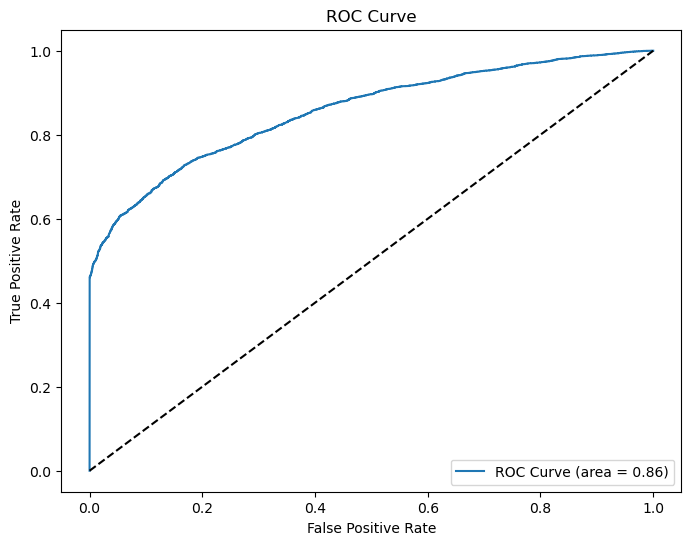

In [54]:
#Ramdom Forest Model
X = data.drop(columns=['y'])
y = data['y']

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_rf = rf_model.predict(X_test)

# 评估模型性能
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# 计算ROC曲线
y_pred_prob = model.predict_proba(X_test)[:, 1]  # 获取预测为1的概率
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 计算AUC值
auc_score_rf = roc_auc_score(y_test, y_pred_prob)

# 打印模型性能指标
print("Random Forest Model:")
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)
print("Classification Report:")
print(classification_rep_rf)
print("AUC Score:", auc_score_rf)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

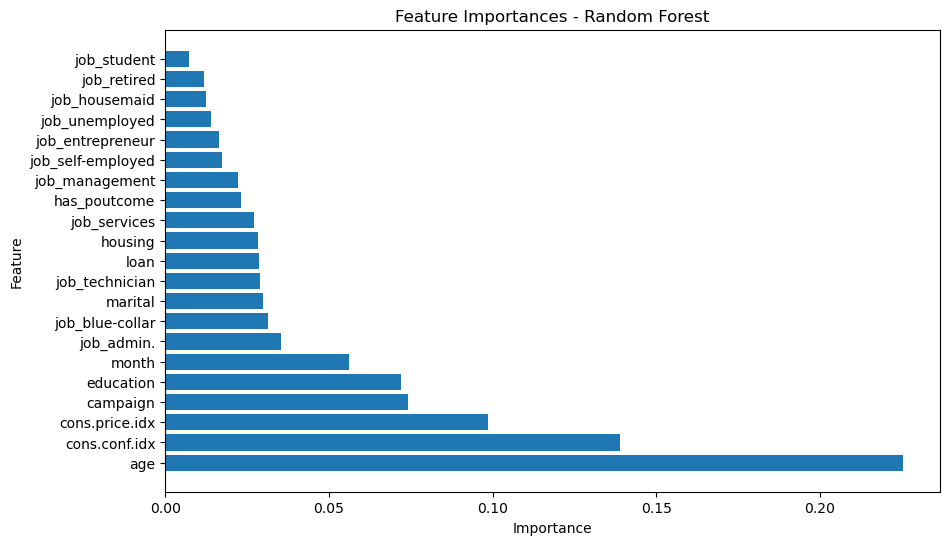

In [55]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Random Forest')
plt.show()

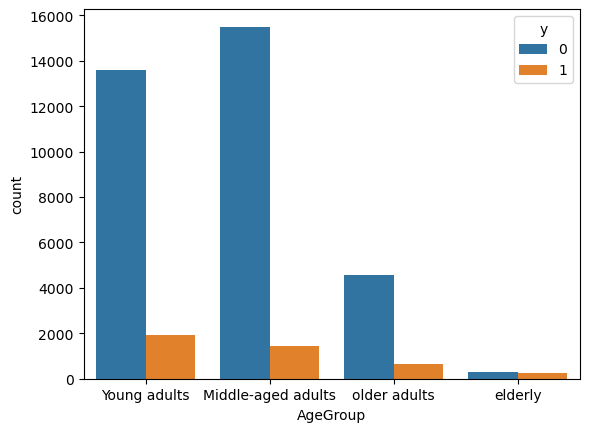

AgeGroup,Young adults,Middle-aged adults,older adults,elderly
y,,,,
0,13609,15504,4570,293
1,1922,1432,651,247


In [56]:
data=unresampled_data
bins = [18, 35, 51, 65, np.inf]
labels = [ 'Young adults', 'Middle-aged adults','older adults', 'elderly']
data['AgeGroup'] = pd.cut(data["age"], bins, labels = labels)
sns.countplot(x='AgeGroup', hue='y', data=data)
plt.show()
contingency_table = pd.crosstab(data['y'], data['AgeGroup'])
contingency_table

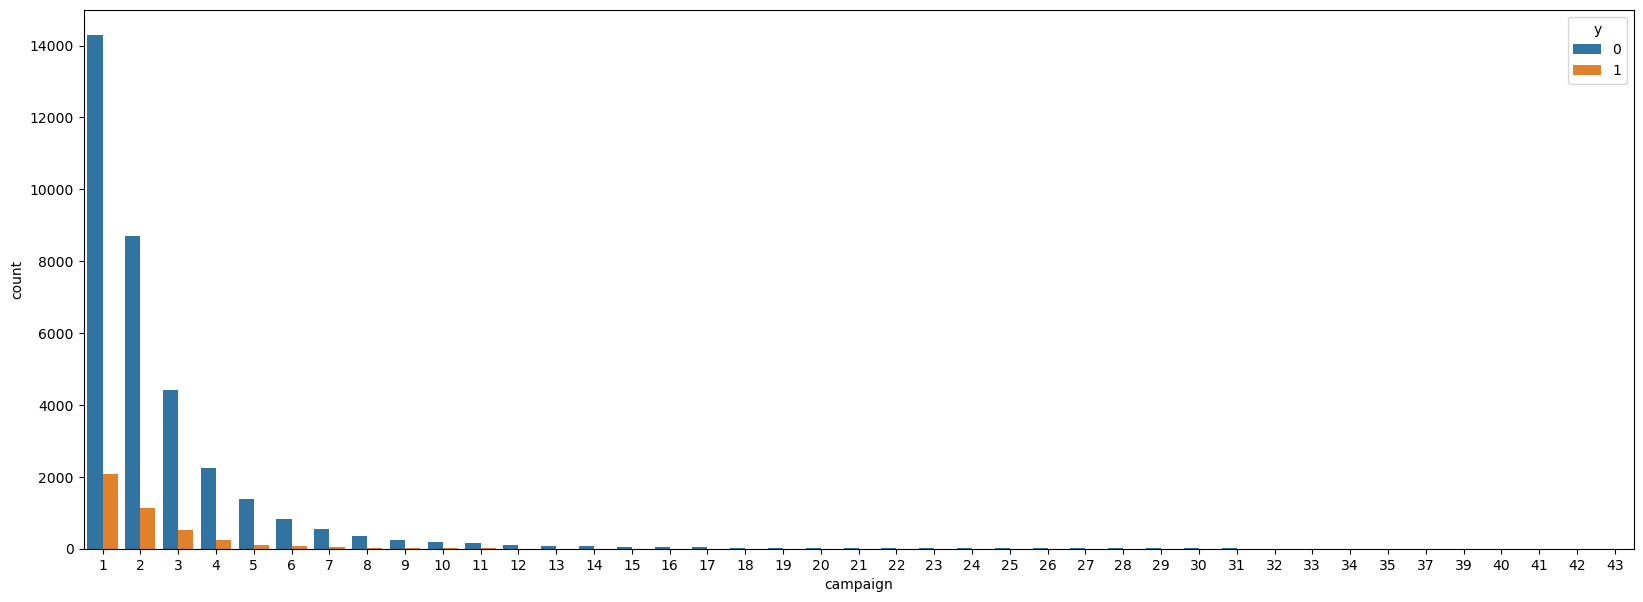

In [57]:
plt.figure(figsize=(20,7))
sns.countplot(x='campaign', hue='y', data=data)
plt.show()